In [211]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.examples.tutorials.mnist import input_data

%matplotlib inline

In [194]:
def import_data():
    
    mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

    X_train = np.vstack([img.reshape(-1,) for img in mnist.train.images])
    Y_train = mnist.train.labels

    X_test = np.vstack([img.reshape(-1,) for img in mnist.test.images])
    Y_test = mnist.test.labels

    del mnist
    
    return X_train, Y_train, X_test, Y_test

In [195]:
def load_data():
    X_train_orig, Y_train_orig, X_test_orig, Y_test_orig = import_data()
    
    X_train_orig = X_train_orig.reshape([-1 , 28,28,1])
    X_test_orig = X_test_orig.reshape([-1 , 28,28,1])
    
    Y_train_orig = Y_train_orig.reshape([1,55000])
    Y_test_orig = Y_test_orig.reshape([1, 10000])
    
    return X_train_orig, Y_train_orig, X_test_orig, Y_test_orig

In [196]:
X_train, Y_train, X_test_orig, Y_test_orig = load_data()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


y = 5


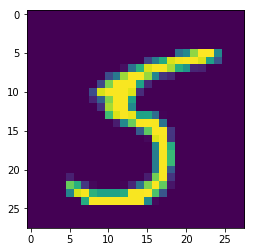

In [197]:
# Example of a picture
index = 54997
plt.imshow(X_train[index,:,:,-1])
print ("y = " + str(np.squeeze(Y_train_orig[index])))

In [198]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [199]:
Y_train = convert_to_one_hot(Y_train_orig, 10).T
Y_test = convert_to_one_hot(Y_test_orig, 10).T

In [200]:
#Sanity Check

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 55000
number of test examples = 10000
X_train shape: (55000, 28, 28, 1)
Y_train shape: (55000, 10)
X_test shape: (10000, 28, 28, 1)
Y_test shape: (10000, 10)


In [201]:
def create_placeholders(n_H0, n_W0,n_C0, n_y):
    X = tf.placeholder(tf.float32, [None, n_H0, n_W0,n_C0])
    Y = tf.placeholder(tf.float32, [None, n_y])
    return X, Y

In [202]:
def initialize_parameters():
    
    W1 = tf.get_variable("W1", [2,2,1,8], initializer =  tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [2,2,8,16], initializer =  tf.contrib.layers.xavier_initializer(seed = 0))
    
    parameters = {"W1": W1,"W2": W2}
    
    return parameters

In [203]:
#Sanity Check

tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1,1]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,1]))

W1 = [[ 0.24109346  0.35657108  0.18549132  0.36647755 -0.17853807  0.33154458
  -0.11004141  0.27762729]]
W2 = [ 0.18771225  0.02089775  0.00491112 -0.12298661 -0.04200333  0.13979024
  0.05375856 -0.10530782 -0.15856427  0.19796973  0.04295498 -0.0471608
  0.01342118  0.21189791  0.1855194  -0.13519925]


In [204]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2,ksize=[1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    
    P2 = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(P2, 10, activation_fn = None)
    
    return Z3

In [205]:
#Sanity Check

tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(28, 28, 1, 10)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,28,28,1), Y: np.random.randn(2,10)})
    print("Z3 = " + str(a))

Z3 = [[-1.28183305  1.94026053  2.64135027 -0.77912563  0.33307946  1.53637862
  -0.53759336  0.59064651  0.5560841  -0.14027019]
 [-1.22697949  1.88026166  2.8098979  -1.02452683  0.63245475  1.53309321
  -0.56476545  0.46089387  0.66751629 -0.17199142]]


In [206]:
def compute_cost(Z3, Y):
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    
    return cost

In [207]:
#Sanity Check

tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(28, 28, 1, 10)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,28,28,1), Y: np.random.randn(4,10)})
    print("cost = " + str(a))

cost = 2.45957


In [208]:
def random_mini_batches(X, Y, mini_batch_size = 100):
        
    m = X.shape[0]                  
    mini_batches = []
    
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [209]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009, num_epochs = 100, minibatch_size = 100, print_cost = True , print_cost_per = 5):
    
    ops.reset_default_graph()
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = [] 
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    
    parameters = initialize_parameters()
    
    Z3 = forward_propagation(X, parameters)
    
    cost = compute_cost(Z3, Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})                
                minibatch_cost += temp_cost / num_minibatches
                
            if print_cost == True and epoch % print_cost_per == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
               
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 1.042676
Cost after epoch 5: 0.349514
Cost after epoch 10: 0.312212
Cost after epoch 15: 0.295604
Cost after epoch 20: 0.289101
Cost after epoch 25: 0.286879
Cost after epoch 30: 0.279748
Cost after epoch 35: 0.279743
Cost after epoch 40: 0.276218
Cost after epoch 45: 0.274697
Cost after epoch 50: 0.274923
Cost after epoch 55: 0.274978
Cost after epoch 60: 0.271697
Cost after epoch 65: 0.266611
Cost after epoch 70: 0.265994
Cost after epoch 75: 0.266185
Cost after epoch 80: 0.265446
Cost after epoch 85: 0.265459
Cost after epoch 90: 0.262028
Cost after epoch 95: 0.262358


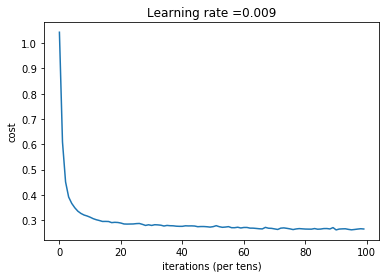

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.923637
Test Accuracy: 0.9255


In [210]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

Cost after epoch 0: 1.466360
Cost after epoch 5: 0.469060
Cost after epoch 10: 0.389163
Cost after epoch 15: 0.347293
Cost after epoch 20: 0.328314
Cost after epoch 25: 0.318281
Cost after epoch 30: 0.309632
Cost after epoch 35: 0.299385
Cost after epoch 40: 0.291452
Cost after epoch 45: 0.286093
Cost after epoch 50: 0.279736
Cost after epoch 55: 0.273509
Cost after epoch 60: 0.267973
Cost after epoch 65: 0.265327
Cost after epoch 70: 0.264216
Cost after epoch 75: 0.262213
Cost after epoch 80: 0.259813
Cost after epoch 85: 0.257459
Cost after epoch 90: 0.256909
Cost after epoch 95: 0.256307


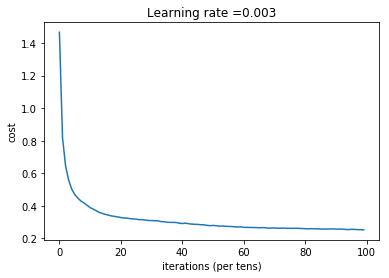

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.921873
Test Accuracy: 0.9202


In [182]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test,learning_rate=0.003)

Cost after epoch 0: 2.211343
Cost after epoch 5: 0.984147
Cost after epoch 10: 0.767081
Cost after epoch 15: 0.637898
Cost after epoch 20: 0.544086
Cost after epoch 25: 0.490668
Cost after epoch 30: 0.457157
Cost after epoch 35: 0.434121
Cost after epoch 40: 0.415058
Cost after epoch 45: 0.398417
Cost after epoch 50: 0.379766
Cost after epoch 55: 0.361623
Cost after epoch 60: 0.347874
Cost after epoch 65: 0.336039
Cost after epoch 70: 0.326922
Cost after epoch 75: 0.321051
Cost after epoch 80: 0.315019
Cost after epoch 85: 0.313096
Cost after epoch 90: 0.311048
Cost after epoch 95: 0.308341


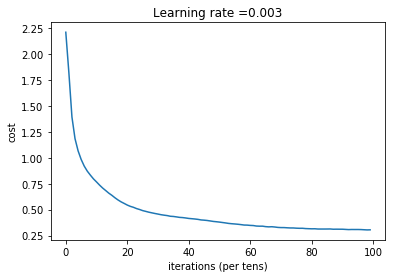

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.902182
Test Accuracy: 0.9056


In [184]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test,learning_rate=0.003, minibatch_size=1000)

Cost after epoch 0: 2.103384
Cost after epoch 5: 0.648131
Cost after epoch 10: 0.501669
Cost after epoch 15: 0.424561
Cost after epoch 20: 0.391601
Cost after epoch 25: 0.376510
Cost after epoch 30: 0.368938
Cost after epoch 35: 0.358018
Cost after epoch 40: 0.350385
Cost after epoch 45: 0.344025
Cost after epoch 50: 0.338548
Cost after epoch 55: 0.335783
Cost after epoch 60: 0.333187
Cost after epoch 65: 0.327838
Cost after epoch 70: 0.326384
Cost after epoch 75: 0.325245
Cost after epoch 80: 0.320493
Cost after epoch 85: 0.317579
Cost after epoch 90: 0.319540
Cost after epoch 95: 0.312029


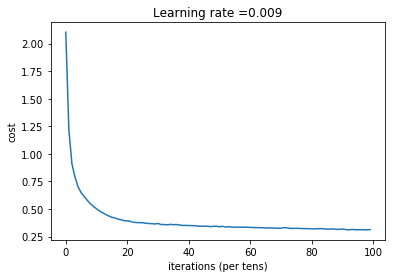

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.901655
Test Accuracy: 0.9064


(0.90165502,
 0.90640014,
 {'W1': <tf.Variable 'W1:0' shape=(2, 2, 1, 8) dtype=float32_ref>,
  'W2': <tf.Variable 'W2:0' shape=(2, 2, 8, 16) dtype=float32_ref>})

In [185]:
model(X_train, Y_train, X_test, Y_test,learning_rate=0.009, minibatch_size=1000)

Cost after epoch 0: 3.607090
Cost after epoch 5: 3.399872
Cost after epoch 10: 3.283303
Cost after epoch 15: 3.063291
Cost after epoch 20: 2.723522
Cost after epoch 25: 2.377064
Cost after epoch 30: 2.112476
Cost after epoch 35: 1.949345
Cost after epoch 40: 1.836875
Cost after epoch 45: 1.757300
Cost after epoch 50: 1.696922
Cost after epoch 55: 1.652940
Cost after epoch 60: 1.618912
Cost after epoch 65: 1.585733
Cost after epoch 70: 1.556843
Cost after epoch 75: 1.525749
Cost after epoch 80: 1.498550
Cost after epoch 85: 1.470703
Cost after epoch 90: 1.442780
Cost after epoch 95: 1.412123


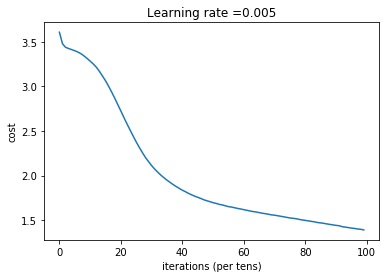

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.683346
Test Accuracy: 0.6881


In [186]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test,learning_rate=0.005, minibatch_size=20000)

Cost after epoch 0: 3.530328
Cost after epoch 50: 1.172444
Cost after epoch 100: 0.893744
Cost after epoch 150: 0.745415
Cost after epoch 200: 0.654074
Cost after epoch 250: 0.591564
Cost after epoch 300: 0.558293
Cost after epoch 350: 0.540511
Cost after epoch 400: 0.533421
Cost after epoch 450: 0.521375
Cost after epoch 500: 0.509807
Cost after epoch 550: 0.506249
Cost after epoch 600: 0.518302
Cost after epoch 650: 0.487861
Cost after epoch 700: 0.467658
Cost after epoch 750: 0.456851
Cost after epoch 800: 0.455939
Cost after epoch 850: 0.446157
Cost after epoch 900: 0.442891
Cost after epoch 950: 0.427236


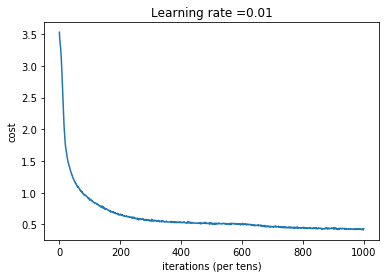

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.9078
Test Accuracy: 0.9087


In [190]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test,learning_rate=0.01, minibatch_size=25000, num_epochs=1000, print_cost_per = 50)